# 데이터 준비

In [ ]:
# 라벨 1,12만 들어있는 이미지
!gdown https://drive.google.com/uc?id=1BG8TXbpOddVEeLW7evRnW9N4H94U3B1P

Downloading...
From: https://drive.google.com/uc?id=1BG8TXbpOddVEeLW7evRnW9N4H94U3B1P
To: /content/id_1_12_image_label.zip
100% 39.1M/39.1M [00:00<00:00, 145MB/s] 


In [ ]:
!unzip id_1_12_image_label.zip

In [ ]:
!rm /content/id_1_12_image_label.zip

In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bbonghag","key":"8cb192135a4913f47ffb76f5565864e2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir yolo_labels
!kaggle datasets download -d awsaf49/vinbigdata-yolo-labels-dataset

100% 4.85M/4.85M [00:00<00:00, 21.3MB/s]
100% 4.85M/4.85M [00:00<00:00, 21.3MB/s]


In [ ]:
!kaggle datasets download -d awsaf49/vinbigdata-512-image-dataset

100% 2.29G/2.30G [00:57<00:00, 49.0MB/s]
100% 2.30G/2.30G [00:57<00:00, 42.8MB/s]


In [ ]:
!unzip -d /content/yolo_labels /content/vinbigdata-yolo-labels-dataset.zip

In [ ]:
!unzip /content/vinbigdata-512-image-dataset.zip

In [ ]:
!rm /content/vinbigdata-512-image-dataset.zip
!rm /content/vinbigdata-yolo-labels-dataset.zip

In [ ]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time
import json
import os
import glob
from PIL import Image

import imgaug.augmenters as iaa
from sklearn.model_selection import GroupKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow


In [ ]:
train_dir = '/content/vinbigdata/train'
test_dir = '/content/vinbigdata/test'
train_df = pd.read_csv('/content/vinbigdata/train.csv')
test_df = pd.read_csv('/content/vinbigdata/test.csv')

In [ ]:
# id = 14 : no finding, 정상 이미지므로 제외.
train_df = train_df[train_df['class_id'] != 14].reset_index(drop=True)
train_df['image_path'] = '/content/vinbigdata/train/'+train_df.image_id+'.png' 

In [ ]:
IMG_SIZE = 512
train_df['xmin'] = ((train_df['x_min']/train_df['width'])*IMG_SIZE).astype('int')
train_df['ymin'] = ((train_df['y_min']/train_df['height'])*IMG_SIZE).astype('int')
train_df['xmax'] = ((train_df['x_max']/train_df['width'])*IMG_SIZE).astype('int')
train_df['ymax'] = ((train_df['y_max']/train_df['height'])*IMG_SIZE).astype('int')

# train_df['xmin'] = (train_df['x_min']/train_df['width'])*IMG_SIZE
# train_df['ymin'] = (train_df['y_min']/train_df['height'])*IMG_SIZE
# train_df['xmax'] = (train_df['x_max']/train_df['width'])*IMG_SIZE
# train_df['ymax'] = (train_df['y_max']/train_df['height'])*IMG_SIZE

train_df['x_mid'] = ((train_df['xmax']+train_df['xmin'])/2)/IMG_SIZE 
train_df['y_mid'] = ((train_df['ymax']+train_df['ymin'])/2)/IMG_SIZE 
train_df['w'] = (train_df['xmax'] - train_df['xmin'])/IMG_SIZE 
train_df['h'] = (train_df['ymax'] - train_df['ymin'])/IMG_SIZE 





In [ ]:
len(os.listdir('/content/image_id1')) +len(os.listdir('/content/image_id12'))

282

1번 이미지 : 186장

12번 이미지 : 96장

총 282장

# Task1. 데이터 다운샘플링

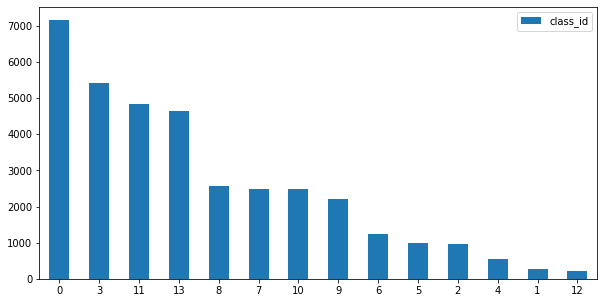

In [ ]:
# 라벨 빈도수 시각화 
df = train_df[['image_id', 'class_id']]
count_df = pd.DataFrame(df.class_id.value_counts()) # 평균값은 2578
count_df.plot.bar(figsize=(10,5), rot=0)

In [ ]:
# 제일 많은 데이터 4개 라벨을 선정 후 다운샘플링하는 코드.
over_list = [0,3,11,13]
for i in over_list:
    id_df = train_df[train_df.class_id == i]
    uni_id = id_df.image_id.unique().tolist() # 라벨이 i인 이미지 파일 이름 리스트 
    for id in uni_id:
        if id_df.image_id.value_counts()[id] > 2: # 빈도수가 2를 넘는 파일이름들을 가져와서 
            id_list = id_df[id_df.image_id == id].index.tolist()[:2]  # 2개씩 자르고 나머지는 남기고 데이터프레임에서 삭제.
            id_df.drop(index=id_list, axis=0, inplace=True)
            if i == 0:
                id_0 = id_df
            elif i == 3:
                id_3 = id_df
            elif i == 11:
                id_11 = id_df
            else:
                id_13 = id_df

reduced_df = pd.concat([id_0, id_3, id_11, id_13], axis=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
reduced_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
5,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0,2304,2880,/content/vinbigdata/train/d3637a1935a905b3c326...,295,132,338,170,0.618164,0.294922,0.083984,0.074219
9,321c111713c3ee5385db0effb54ff568,Aortic enlargement,0,R8,1292.0,554.0,1477.0,805.0,2304,2880,/content/vinbigdata/train/321c111713c3ee5385db...,287,98,328,143,0.600586,0.235352,0.080078,0.087891
12,fb8e11c6b2886b2d41b379e0598669b9,Aortic enlargement,0,R10,1390.0,878.0,1616.0,1163.0,2304,2880,/content/vinbigdata/train/fb8e11c6b2886b2d41b3...,308,156,359,206,0.651367,0.353516,0.099609,0.097656
70,51a8d7259a0a6deac20b7c4979a7e847,Aortic enlargement,0,R14,841.0,510.0,1446.0,888.0,2174,2234,/content/vinbigdata/train/51a8d7259a0a6deac20b...,198,116,340,203,0.525391,0.311523,0.277344,0.169922
96,381e9c224c892d437f498779e349469e,Aortic enlargement,0,R10,1481.0,875.0,1674.0,1097.0,2571,2666,/content/vinbigdata/train/381e9c224c892d437f49...,294,168,333,210,0.612305,0.369141,0.076172,0.082031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36043,a99a720cab88405baaf789e85ce20c45,Pulmonary fibrosis,13,R9,526.0,569.0,931.0,1133.0,2304,2880,/content/vinbigdata/train/a99a720cab88405baaf7...,116,101,206,201,0.314453,0.294922,0.175781,0.195312
36062,b6bb5088976d0d3d51f3041b2172cffb,Pulmonary fibrosis,13,R9,510.0,554.0,999.0,1108.0,2544,2828,/content/vinbigdata/train/b6bb5088976d0d3d51f3...,102,100,201,200,0.295898,0.292969,0.193359,0.195312
36064,93ed73782bc23a0ef9c426c21982d8d7,Pulmonary fibrosis,13,R8,1838.0,1258.0,2225.0,1419.0,2613,3005,/content/vinbigdata/train/93ed73782bc23a0ef9c4...,360,214,435,241,0.776367,0.444336,0.146484,0.052734
36077,cc47c14b9aa97e08fad1925a6dc1efee,Pulmonary fibrosis,13,R9,643.0,726.0,1202.0,1251.0,2753,2776,/content/vinbigdata/train/cc47c14b9aa97e08fad1...,119,133,223,230,0.333984,0.354492,0.203125,0.189453


In [ ]:
# 라벨 0, 3, 11, 13 번 제외.
train_df1 = train_df[(train_df.class_id != 0) & (train_df.class_id != 3) & (train_df.class_id != 11) & (train_df.class_id != 13)]
train_df1

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555,/content/vinbigdata/train/0c7a38f293d5f5e4846a...,301,49,490,434,0.772461,0.471680,0.369141,0.751953
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,/content/vinbigdata/train/47ed17dcb2cbeec15182...,111,359,134,379,0.239258,0.720703,0.044922,0.039062
7,7c1add6833d5f0102b0d3619a1682a64,Lung Opacity,7,R10,600.0,1332.0,903.0,1523.0,2944,3014,/content/vinbigdata/train/7c1add6833d5f0102b0d...,104,226,157,258,0.254883,0.472656,0.103516,0.062500
10,80caa435b6ab5edaff4a0a758ffaec6e,Atelectasis,1,R9,331.0,462.0,1384.0,2365.0,3001,3107,/content/vinbigdata/train/80caa435b6ab5edaff4a...,56,76,236,389,0.285156,0.454102,0.351562,0.611328
16,c394eadea89e5795c8037280492d116d,Other lesion,9,R9,0.0,839.0,274.0,2168.0,2304,2880,/content/vinbigdata/train/c394eadea89e5795c803...,0,149,60,385,0.058594,0.521484,0.117188,0.460938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36088,66332eb5425bcdc6854aae970cc656b9,Nodule/Mass,8,R8,2161.0,1600.0,2308.0,1758.0,2936,2963,/content/vinbigdata/train/66332eb5425bcdc6854a...,376,276,402,303,0.759766,0.565430,0.050781,0.052734
36090,3b887c0550e9722c9b86b7c22ad09e11,Other lesion,9,R10,254.0,1959.0,280.0,1990.0,2630,3073,/content/vinbigdata/train/3b887c0550e9722c9b86...,49,326,54,331,0.100586,0.641602,0.009766,0.009766
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880,/content/vinbigdata/train/b53d1dd80e99ca6bcef9...,53,275,124,355,0.172852,0.615234,0.138672,0.156250
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500,/content/vinbigdata/train/22672ab82c290c20b868...,74,135,198,308,0.265625,0.432617,0.242188,0.337891


In [ ]:
total_df = pd.concat([reduced_df, train_df1], axis=0).reset_index().drop('index', axis=1)
total_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
0,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0,2304,2880,/content/vinbigdata/train/d3637a1935a905b3c326...,295,132,338,170,0.618164,0.294922,0.083984,0.074219
1,321c111713c3ee5385db0effb54ff568,Aortic enlargement,0,R8,1292.0,554.0,1477.0,805.0,2304,2880,/content/vinbigdata/train/321c111713c3ee5385db...,287,98,328,143,0.600586,0.235352,0.080078,0.087891
2,fb8e11c6b2886b2d41b379e0598669b9,Aortic enlargement,0,R10,1390.0,878.0,1616.0,1163.0,2304,2880,/content/vinbigdata/train/fb8e11c6b2886b2d41b3...,308,156,359,206,0.651367,0.353516,0.099609,0.097656
3,51a8d7259a0a6deac20b7c4979a7e847,Aortic enlargement,0,R14,841.0,510.0,1446.0,888.0,2174,2234,/content/vinbigdata/train/51a8d7259a0a6deac20b...,198,116,340,203,0.525391,0.311523,0.277344,0.169922
4,381e9c224c892d437f498779e349469e,Aortic enlargement,0,R10,1481.0,875.0,1674.0,1097.0,2571,2666,/content/vinbigdata/train/381e9c224c892d437f49...,294,168,333,210,0.612305,0.369141,0.076172,0.082031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27017,66332eb5425bcdc6854aae970cc656b9,Nodule/Mass,8,R8,2161.0,1600.0,2308.0,1758.0,2936,2963,/content/vinbigdata/train/66332eb5425bcdc6854a...,376,276,402,303,0.759766,0.565430,0.050781,0.052734
27018,3b887c0550e9722c9b86b7c22ad09e11,Other lesion,9,R10,254.0,1959.0,280.0,1990.0,2630,3073,/content/vinbigdata/train/3b887c0550e9722c9b86...,49,326,54,331,0.100586,0.641602,0.009766,0.009766
27019,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880,/content/vinbigdata/train/b53d1dd80e99ca6bcef9...,53,275,124,355,0.172852,0.615234,0.138672,0.156250
27020,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500,/content/vinbigdata/train/22672ab82c290c20b868...,74,135,198,308,0.265625,0.432617,0.242188,0.337891


In [ ]:
total_df = total_df[['image_id', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax', 'x_mid', 'y_mid', 'w', 'h']]
total_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
0,d3637a1935a905b3c326af31389cb846,0,295,132,338,170,0.618164,0.294922,0.083984,0.074219
1,321c111713c3ee5385db0effb54ff568,0,287,98,328,143,0.600586,0.235352,0.080078,0.087891
2,fb8e11c6b2886b2d41b379e0598669b9,0,308,156,359,206,0.651367,0.353516,0.099609,0.097656
3,51a8d7259a0a6deac20b7c4979a7e847,0,198,116,340,203,0.525391,0.311523,0.277344,0.169922
4,381e9c224c892d437f498779e349469e,0,294,168,333,210,0.612305,0.369141,0.076172,0.082031
...,...,...,...,...,...,...,...,...,...,...
27017,66332eb5425bcdc6854aae970cc656b9,8,376,276,402,303,0.759766,0.565430,0.050781,0.052734
27018,3b887c0550e9722c9b86b7c22ad09e11,9,49,326,54,331,0.100586,0.641602,0.009766,0.009766
27019,b53d1dd80e99ca6bcef9d592f65d3321,10,53,275,124,355,0.172852,0.615234,0.138672,0.156250
27020,22672ab82c290c20b86863291e25ef6c,5,74,135,198,308,0.265625,0.432617,0.242188,0.337891


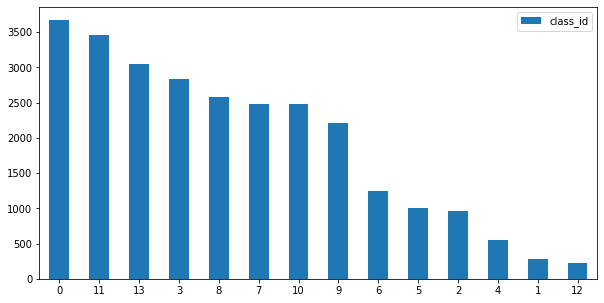

In [ ]:
count1_df = pd.DataFrame(total_df.class_id.value_counts())
count1_df.plot.bar(figsize=(10,5), rot=0)

과하게 높던 상위 4개 라벨들을 평균값과의 차이를 많이 줄임

In [ ]:
total_df.class_id.value_counts()

0     3672
11    3464
13    3047
3     2829
8     2580
7     2483
10    2476
9     2203
6     1247
5     1000
2      960
4      556
1      279
12     226
Name: class_id, dtype: int64

# Task2. 이미지 증강

## 1. clahe & equ image

In [ ]:
%mv /content/image_id12/* /content/image_id1/ 
!rm -r /content/image_id12 

In [ ]:
len(os.listdir('/content/image_id1'))

266

In [ ]:
# 1,12번 이미지 경로 리스트 
input_path = "/content/image_id1/*.png"
image_list = [f for f in glob.glob(input_path)]

In [ ]:
!mkdir /content/aug_image

In [ ]:
# clahe image 만들기 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for path in image_list:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    clahe_img = clahe.apply(img)
    img_name = path.split('/')[-1].split('.')[0]
    cv2.imwrite(f'/content/aug_image/{img_name}'+'_clahe.png', clahe_img)
  

In [ ]:
# # clahe image 생성 함수
# def clahe_image(image_list):
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     for path in image_list:
#         img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#         clahe_img = clahe.apply(img)
#         img_name = path.split('/')[-1].split('.')[0]
#         cv2.imwrite(f'/content/aug_image/{img_name}'+'_clahe.png', clahe_img)


In [ ]:
# equalizeHist image 만들기 
for path in image_list:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    equ_img = cv2.equalizeHist(img)
    img_name = path.split('/')[-1].split('.')[0]
    cv2.imwrite(f'/content/aug_image/{img_name}'+'_equ.png', equ_img)


In [ ]:
# equalizeHist image 만들기 

# def equ_image(image_list):
#     for path in image_list:
#         img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#         equ_img = cv2.equalizeHist(img)
#         img_name = path.split('/')[-1].split('.')[0]
#         cv2.imwrite(f'/content/aug_image/{img_name}'+'_equ.png', equ_img)

# equ_image(image_list)

In [ ]:
# 1,12번 이미지 데이터프레임. 여기 image_id에 증강한 이미지 이름이랑 맞게 바꿔서 total_df에 추가해주면 된다.
# image_id 뒤에 _clahe, _equ 추가하기.
less_df = total_df[(total_df.class_id == 1) | (total_df.class_id == 12) ]
less_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
13015,80caa435b6ab5edaff4a0a758ffaec6e,1,56,76,236,389,0.285156,0.454102,0.351562,0.611328
13055,6e4391555899c8474c4d32f42b2ba21b,12,328,93,402,166,0.712891,0.252930,0.144531,0.142578
13066,8098d1ce056318c03a3c70ccf3707945,1,235,105,350,151,0.571289,0.250000,0.224609,0.089844
13074,e3c5ff1eb0d55039f3bbc3c4875543c3,12,59,260,242,340,0.293945,0.585938,0.357422,0.156250
13098,fb31baa6cb3084cb283c11ee81c32f22,1,373,88,421,133,0.775391,0.215820,0.093750,0.087891
...,...,...,...,...,...,...,...,...,...,...
26853,0abd4fc2425edd5c2efb2c149e9319c6,1,286,69,349,144,0.620117,0.208008,0.123047,0.146484
26888,2f4573aa154b6ee5f4ba4dc90626f5ec,1,301,105,376,269,0.661133,0.365234,0.146484,0.320312
26896,2583527ca7c4a6e278fb4506ba8637ab,12,77,299,198,366,0.268555,0.649414,0.236328,0.130859
26943,4e3a3b03cf00a9060ac139f57843a241,12,306,68,414,156,0.703125,0.218750,0.210938,0.171875


In [ ]:
equ_df = less_df.copy()
equ_df['image_id'] = equ_df['image_id'] + '_equ'
equ_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
13015,80caa435b6ab5edaff4a0a758ffaec6e_equ,1,56,76,236,389,0.285156,0.454102,0.351562,0.611328
13055,6e4391555899c8474c4d32f42b2ba21b_equ,12,328,93,402,166,0.712891,0.252930,0.144531,0.142578
13066,8098d1ce056318c03a3c70ccf3707945_equ,1,235,105,350,151,0.571289,0.250000,0.224609,0.089844
13074,e3c5ff1eb0d55039f3bbc3c4875543c3_equ,12,59,260,242,340,0.293945,0.585938,0.357422,0.156250
13098,fb31baa6cb3084cb283c11ee81c32f22_equ,1,373,88,421,133,0.775391,0.215820,0.093750,0.087891
...,...,...,...,...,...,...,...,...,...,...
26853,0abd4fc2425edd5c2efb2c149e9319c6_equ,1,286,69,349,144,0.620117,0.208008,0.123047,0.146484
26888,2f4573aa154b6ee5f4ba4dc90626f5ec_equ,1,301,105,376,269,0.661133,0.365234,0.146484,0.320312
26896,2583527ca7c4a6e278fb4506ba8637ab_equ,12,77,299,198,366,0.268555,0.649414,0.236328,0.130859
26943,4e3a3b03cf00a9060ac139f57843a241_equ,12,306,68,414,156,0.703125,0.218750,0.210938,0.171875


In [ ]:
clahe_df = less_df.copy()
clahe_df['image_id'] = clahe_df['image_id'] + '_clahe'
clahe_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
13015,80caa435b6ab5edaff4a0a758ffaec6e_clahe,1,56,76,236,389,0.285156,0.454102,0.351562,0.611328
13055,6e4391555899c8474c4d32f42b2ba21b_clahe,12,328,93,402,166,0.712891,0.252930,0.144531,0.142578
13066,8098d1ce056318c03a3c70ccf3707945_clahe,1,235,105,350,151,0.571289,0.250000,0.224609,0.089844
13074,e3c5ff1eb0d55039f3bbc3c4875543c3_clahe,12,59,260,242,340,0.293945,0.585938,0.357422,0.156250
13098,fb31baa6cb3084cb283c11ee81c32f22_clahe,1,373,88,421,133,0.775391,0.215820,0.093750,0.087891
...,...,...,...,...,...,...,...,...,...,...
26853,0abd4fc2425edd5c2efb2c149e9319c6_clahe,1,286,69,349,144,0.620117,0.208008,0.123047,0.146484
26888,2f4573aa154b6ee5f4ba4dc90626f5ec_clahe,1,301,105,376,269,0.661133,0.365234,0.146484,0.320312
26896,2583527ca7c4a6e278fb4506ba8637ab_clahe,12,77,299,198,366,0.268555,0.649414,0.236328,0.130859
26943,4e3a3b03cf00a9060ac139f57843a241_clahe,12,306,68,414,156,0.703125,0.218750,0.210938,0.171875


In [ ]:
# 원본 이미지 + 1,12번 equ + 1,12번 clahe
aug_df = pd.concat([total_df, equ_df, clahe_df], axis=0).reset_index().drop('index', axis=1)
aug_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
0,d3637a1935a905b3c326af31389cb846,0,295,132,338,170,0.618164,0.294922,0.083984,0.074219
1,321c111713c3ee5385db0effb54ff568,0,287,98,328,143,0.600586,0.235352,0.080078,0.087891
2,fb8e11c6b2886b2d41b379e0598669b9,0,308,156,359,206,0.651367,0.353516,0.099609,0.097656
3,51a8d7259a0a6deac20b7c4979a7e847,0,198,116,340,203,0.525391,0.311523,0.277344,0.169922
4,381e9c224c892d437f498779e349469e,0,294,168,333,210,0.612305,0.369141,0.076172,0.082031
...,...,...,...,...,...,...,...,...,...,...
28027,0abd4fc2425edd5c2efb2c149e9319c6_clahe,1,286,69,349,144,0.620117,0.208008,0.123047,0.146484
28028,2f4573aa154b6ee5f4ba4dc90626f5ec_clahe,1,301,105,376,269,0.661133,0.365234,0.146484,0.320312
28029,2583527ca7c4a6e278fb4506ba8637ab_clahe,12,77,299,198,366,0.268555,0.649414,0.236328,0.130859
28030,4e3a3b03cf00a9060ac139f57843a241_clahe,12,306,68,414,156,0.703125,0.218750,0.210938,0.171875


## 2. flip image

In [ ]:
# flip image 만들기
for path in image_list:
    img = cv2.imread(path)
    flipped_img = cv2.flip(img, 1) 
    img_name = path.split('/')[-1].split('.')[0]
    cv2.imwrite(f'/content/aug_image/{img_name}'+'_flip.png', flipped_img)


In [ ]:
# def flip_image(image_list):
#     for path in image_list:
#         img = cv2.imread(path)
#         flipped_img = cv2.flip(img, 1) 
#         img_name = path.split('/')[-1].split('.')[0]
#         cv2.imwrite(f'/content/aug_image/{img_name}'+'_flip.png', flipped_img)

# flip_image(image_list)

In [ ]:
# 플립된 이미지의 x_mid, y_mid 구해서 추가 / flip bbox 계산 : (256-x_min,y_min), (256-x_max,y_max)
# 플립시 바운딩박스의 x좌표가 변하므로 바뀐 좌표로 바꿔줘야 한다.
flip_df = less_df.copy()
flip_df['x_mid'] = (((512 - flip_df['xmin'])+(512 - flip_df['xmax']))//2)/512
flip_df['y_mid'] = ((flip_df['ymin'] + flip_df['ymax'])//2)/512
flip_df['image_id'] = flip_df['image_id'] + '_flip'
flip_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
13015,80caa435b6ab5edaff4a0a758ffaec6e_flip,1,56,76,236,389,0.714844,0.453125,0.351562,0.611328
13055,6e4391555899c8474c4d32f42b2ba21b_flip,12,328,93,402,166,0.287109,0.251953,0.144531,0.142578
13066,8098d1ce056318c03a3c70ccf3707945_flip,1,235,105,350,151,0.427734,0.250000,0.224609,0.089844
13074,e3c5ff1eb0d55039f3bbc3c4875543c3_flip,12,59,260,242,340,0.705078,0.585938,0.357422,0.156250
13098,fb31baa6cb3084cb283c11ee81c32f22_flip,1,373,88,421,133,0.224609,0.214844,0.093750,0.087891
...,...,...,...,...,...,...,...,...,...,...
26853,0abd4fc2425edd5c2efb2c149e9319c6_flip,1,286,69,349,144,0.378906,0.207031,0.123047,0.146484
26888,2f4573aa154b6ee5f4ba4dc90626f5ec_flip,1,301,105,376,269,0.337891,0.365234,0.146484,0.320312
26896,2583527ca7c4a6e278fb4506ba8637ab_flip,12,77,299,198,366,0.730469,0.648438,0.236328,0.130859
26943,4e3a3b03cf00a9060ac139f57843a241_flip,12,306,68,414,156,0.296875,0.218750,0.210938,0.171875


In [ ]:
aug_df = pd.concat([total_df, equ_df, clahe_df, flip_df], axis=0).reset_index().drop('index', axis=1)
aug_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
0,d3637a1935a905b3c326af31389cb846,0,295,132,338,170,0.618164,0.294922,0.083984,0.074219
1,321c111713c3ee5385db0effb54ff568,0,287,98,328,143,0.600586,0.235352,0.080078,0.087891
2,fb8e11c6b2886b2d41b379e0598669b9,0,308,156,359,206,0.651367,0.353516,0.099609,0.097656
3,51a8d7259a0a6deac20b7c4979a7e847,0,198,116,340,203,0.525391,0.311523,0.277344,0.169922
4,381e9c224c892d437f498779e349469e,0,294,168,333,210,0.612305,0.369141,0.076172,0.082031
...,...,...,...,...,...,...,...,...,...,...
28532,0abd4fc2425edd5c2efb2c149e9319c6_flip,1,286,69,349,144,0.378906,0.207031,0.123047,0.146484
28533,2f4573aa154b6ee5f4ba4dc90626f5ec_flip,1,301,105,376,269,0.337891,0.365234,0.146484,0.320312
28534,2583527ca7c4a6e278fb4506ba8637ab_flip,12,77,299,198,366,0.730469,0.648438,0.236328,0.130859
28535,4e3a3b03cf00a9060ac139f57843a241_flip,12,306,68,414,156,0.296875,0.218750,0.210938,0.171875


## 3.rotation 90 image (counter clock)

In [ ]:
image_list[0]

'/content/image_id1/c978cdb3275ab78fe11929e145dedab2.png'

In [ ]:
# rotation image 만들기 (반시계 90도)
for path in image_list:
    img = cv2.imread(path)
    (h, w) = img.shape[:2]
    (cX, cY) = (w/2, h/2)
    M = cv2.getRotationMatrix2D((cX,cY), 90, 1.0)
    rotated_img = cv2.warpAffine(img, M, (w,h))
    img_name = path.split('/')[-1].split('.')[0]
    cv2.imwrite(f'/content/aug_image/{img_name}'+'_rotated.png', rotated_img)


In [ ]:

# def rotation_image(image_list):
#     for path in image_list:
#         img = cv2.imread(path)
#         (h, w) = img.shape[:2]
#         (cX, cY) = (w/2, h/2)
#         M = cv2.getRotationMatrix2D((cX,cY), 90, 1.0)
#         rotated_img = cv2.warpAffine(img, M, (w,h))
#         img_name = path.split('/')[-1].split('.')[0]
#         cv2.imwrite(f'/content/aug_image/{img_name}'+'_rotated.png', rotated_img)

# rotation_image(image_list)

In [ ]:
import math 

def cossin(angle):
  cos = math.cos(math.pi*(angle/180))
  sin = math.sin(math.pi*(angle/180))

  return cos, sin

cos, sin = cossin(90)
print(cos, sin)

6.123233995736766e-17 1.0


In [ ]:
ro_90 = less_df.copy()

# 노멀리제이션되있는 mid값들을 512를 곱해서 원래 픽셀값으로 되돌리고 계산을 해줌.
ro_90["x_mid"] = ro_90.apply(lambda row: ((row.x_mid*512*cos - row.y_mid*512*sin) + 512)/512, axis =1)
ro_90["y_mid"] = ro_90.apply(lambda row: ((row.x_mid*512*sin + row.y_mid*512*cos))/512, axis =1)
ro_90['image_id'] = ro_90['image_id'] + '_rotated'
ro_90

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
13015,80caa435b6ab5edaff4a0a758ffaec6e_rotated,1,56,76,236,389,0.545898,0.545898,0.351562,0.611328
13055,6e4391555899c8474c4d32f42b2ba21b_rotated,12,328,93,402,166,0.747070,0.747070,0.144531,0.142578
13066,8098d1ce056318c03a3c70ccf3707945_rotated,1,235,105,350,151,0.750000,0.750000,0.224609,0.089844
13074,e3c5ff1eb0d55039f3bbc3c4875543c3_rotated,12,59,260,242,340,0.414062,0.414063,0.357422,0.156250
13098,fb31baa6cb3084cb283c11ee81c32f22_rotated,1,373,88,421,133,0.784180,0.784180,0.093750,0.087891
...,...,...,...,...,...,...,...,...,...,...
26853,0abd4fc2425edd5c2efb2c149e9319c6_rotated,1,286,69,349,144,0.791992,0.791992,0.123047,0.146484
26888,2f4573aa154b6ee5f4ba4dc90626f5ec_rotated,1,301,105,376,269,0.634766,0.634766,0.146484,0.320312
26896,2583527ca7c4a6e278fb4506ba8637ab_rotated,12,77,299,198,366,0.350586,0.350586,0.236328,0.130859
26943,4e3a3b03cf00a9060ac139f57843a241_rotated,12,306,68,414,156,0.781250,0.781250,0.210938,0.171875


In [ ]:
aug_df = pd.concat([total_df, equ_df, clahe_df, flip_df, ro_90], axis=0).reset_index().drop('index', axis=1)
aug_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
0,d3637a1935a905b3c326af31389cb846,0,295,132,338,170,0.618164,0.294922,0.083984,0.074219
1,321c111713c3ee5385db0effb54ff568,0,287,98,328,143,0.600586,0.235352,0.080078,0.087891
2,fb8e11c6b2886b2d41b379e0598669b9,0,308,156,359,206,0.651367,0.353516,0.099609,0.097656
3,51a8d7259a0a6deac20b7c4979a7e847,0,198,116,340,203,0.525391,0.311523,0.277344,0.169922
4,381e9c224c892d437f498779e349469e,0,294,168,333,210,0.612305,0.369141,0.076172,0.082031
...,...,...,...,...,...,...,...,...,...,...
29037,0abd4fc2425edd5c2efb2c149e9319c6_rotated,1,286,69,349,144,0.791992,0.791992,0.123047,0.146484
29038,2f4573aa154b6ee5f4ba4dc90626f5ec_rotated,1,301,105,376,269,0.634766,0.634766,0.146484,0.320312
29039,2583527ca7c4a6e278fb4506ba8637ab_rotated,12,77,299,198,366,0.350586,0.350586,0.236328,0.130859
29040,4e3a3b03cf00a9060ac139f57843a241_rotated,12,306,68,414,156,0.781250,0.781250,0.210938,0.171875


## 4.cutmix image

### generating a batch of data


Image labels: [[0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]]



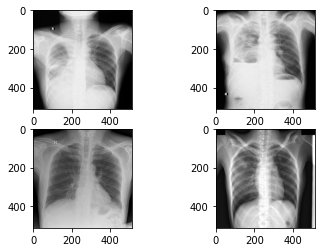

In [ ]:
# #SAMPLE -> 우린 그럼 n_images를 4가아닌 총 images개수로 바꿔줘야겠지!
# # Create batch of 4 images

# image_batch = []
# image_batch_labels = []

# n_images = 4

# for i in range(n_images):
#     image = cv2.cvtColor(cv2.imread(image_list[i]), cv2.COLOR_BGR2RGB)
#     image_batch.append(image)
    
#     label_temp = list(np.floor(np.random.rand(1)*2.99).astype(int))[0]
#     if label_temp == 0:
#         label = [1,0,0]
#     elif label_temp == 1:
#         label = [0,1,0]
#     else: # label_temp == 2
#         label = [0,0,1]
    
#     image_batch_labels.append(label)

# # Convert image_batch to numpy array
# image_batch = np.array(image_batch)
# # Conver image_batch_labels to numpy array
# image_batch_labels = np.array(image_batch_labels)
    
# # Print labels
# print()
# print(f"Image labels: {image_batch_labels}\n")

# # Show images
# for i in range(2):
#     for j in range(2):
#         plt.subplot(2,2,2*i+j+1)
#         plt.imshow(image_batch[2*i+j])
# plt.show()

### generating random bounding box

In [ ]:
def rand_bbox(size, lamb):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

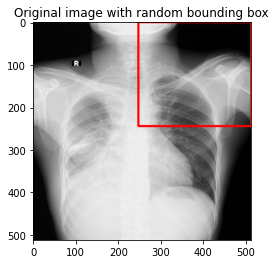

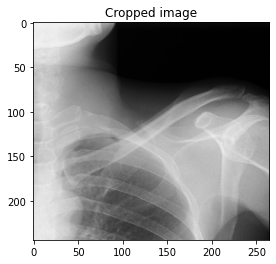

In [ ]:
# #SAMPLE
# # Read an image
# image = cv2.cvtColor(cv2.imread(image_list[0]), cv2.COLOR_BGR2RGB)

# # Crop a random bounding box
# lamb = 0.7
# size = image.shape
# bbox = rand_bbox(size, lamb)

# # Draw bounding box on the image
# im = image.copy()
# x1 = bbox[0]
# y1 = bbox[1]
# x2 = bbox[2]
# y2 = bbox[3]
# cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 3)
# plt.imshow(im);
# plt.title('Original image with random bounding box')
# plt.show();

# # Show cropped image
# plt.imshow(image[y1:y2, x1:x2]);
# plt.title('Cropped image')
# plt.show()

In [ ]:
# REAL
# 우린 그럼 n_images를 4가아닌 총 images개수로 바꿔줘야겠지!
# Create batch of 4394 images

image_batch = []
image_batch_labels = []

n_images = len(image_list)
from tqdm import tqdm
for i in tqdm(range(n_images)):
    image = cv2.cvtColor(cv2.imread(image_list[i]), cv2.COLOR_BGR2RGB)
    image_batch.append(image)
    
    label_temp = list(np.floor(np.random.rand(1)*2.99).astype(int))[0]
    if label_temp == 0:
        label = [1,0,0]
    elif label_temp == 1:
        label = [0,1,0]
    else: # label_temp == 2
        label = [0,0,1]
    
    image_batch_labels.append(label)

# Convert image_batch to numpy array
image_batch = np.array(image_batch) #4394개가 들어감
# Conver image_batch_labels to numpy array
image_batch_labels = np.array(image_batch_labels) #4394개가 들어감

100%|██████████| 266/266 [00:00<00:00, 282.25it/s]


In [ ]:
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return image_batch_updated, label

In [ ]:
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch, image_batch_labels, 0.6)
for i,path in tqdm(enumerate(image_list)):
  image = image_batch_updated[i]
  img_name = path.split('/')[-1].split('.')[0]
  cv2.imwrite(f"/content/aug_image/{img_name}_cutmix.png", image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

In [ ]:
def rand_bbox(size, lamb):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2



def make_img_batch_labels(image_list):
    image_batch = []
    image_batch_labels = []
    n_images = len(image_list)

    for i in tqdm(range(n_images)):
        image = cv2.cvtColor(cv2.imread(image_list[i]), cv2.COLOR_BGR2RGB)
        image_batch.append(image)
    
        label_temp = list(np.floor(np.random.rand(1)*2.99).astype(int))[0]
        if label_temp == 0:
            label = [1,0,0]
        elif label_temp == 1:
            label = [0,1,0]
        else: # label_temp == 2
            label = [0,0,1]
    
        image_batch_labels.append(label)

    # Convert image_batch to numpy array
    image_batch = np.array(image_batch) 
    # Conver image_batch_labels to numpy array
    image_batch_labels = np.array(image_batch_labels) 
    
    return image_batch, image_batch_labels



def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return image_batch_updated, label



image_batch, image_batch_labels = make_img_batch_labels(image_list)
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch, image_batch_labels, 0.6)

def cutmix_image(image_list):
    for i,path in tqdm(enumerate(image_list)):
        image = image_batch_updated[i]
        img_name = path.split('/')[-1].split('.')[0]
        cv2.imwrite(f"/content/aug_image/{img_name}_cutmix.png", image)

cutmix_image(image_list)




100%|██████████| 266/266 [00:00<00:00, 278.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the

In [ ]:
!rm /content/aug_image/*

In [ ]:
cutmix_df = less_df.copy()
cutmix_df['image_id'] = cutmix_df['image_id'] + '_cutmix'
cutmix_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
13015,80caa435b6ab5edaff4a0a758ffaec6e_cutmix,1,56,76,236,389,0.285156,0.454102,0.351562,0.611328
13055,6e4391555899c8474c4d32f42b2ba21b_cutmix,12,328,93,402,166,0.712891,0.252930,0.144531,0.142578
13066,8098d1ce056318c03a3c70ccf3707945_cutmix,1,235,105,350,151,0.571289,0.250000,0.224609,0.089844
13074,e3c5ff1eb0d55039f3bbc3c4875543c3_cutmix,12,59,260,242,340,0.293945,0.585938,0.357422,0.156250
13098,fb31baa6cb3084cb283c11ee81c32f22_cutmix,1,373,88,421,133,0.775391,0.215820,0.093750,0.087891
...,...,...,...,...,...,...,...,...,...,...
26853,0abd4fc2425edd5c2efb2c149e9319c6_cutmix,1,286,69,349,144,0.620117,0.208008,0.123047,0.146484
26888,2f4573aa154b6ee5f4ba4dc90626f5ec_cutmix,1,301,105,376,269,0.661133,0.365234,0.146484,0.320312
26896,2583527ca7c4a6e278fb4506ba8637ab_cutmix,12,77,299,198,366,0.268555,0.649414,0.236328,0.130859
26943,4e3a3b03cf00a9060ac139f57843a241_cutmix,12,306,68,414,156,0.703125,0.218750,0.210938,0.171875


In [ ]:
aug_df = pd.concat([total_df, equ_df, clahe_df, flip_df, ro_90, cutmix_df], axis=0).reset_index().drop('index', axis=1)
aug_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
0,d3637a1935a905b3c326af31389cb846,0,295,132,338,170,0.618164,0.294922,0.083984,0.074219
1,321c111713c3ee5385db0effb54ff568,0,287,98,328,143,0.600586,0.235352,0.080078,0.087891
2,fb8e11c6b2886b2d41b379e0598669b9,0,308,156,359,206,0.651367,0.353516,0.099609,0.097656
3,51a8d7259a0a6deac20b7c4979a7e847,0,198,116,340,203,0.525391,0.311523,0.277344,0.169922
4,381e9c224c892d437f498779e349469e,0,294,168,333,210,0.612305,0.369141,0.076172,0.082031
...,...,...,...,...,...,...,...,...,...,...
29542,0abd4fc2425edd5c2efb2c149e9319c6_cutmix,1,286,69,349,144,0.620117,0.208008,0.123047,0.146484
29543,2f4573aa154b6ee5f4ba4dc90626f5ec_cutmix,1,301,105,376,269,0.661133,0.365234,0.146484,0.320312
29544,2583527ca7c4a6e278fb4506ba8637ab_cutmix,12,77,299,198,366,0.268555,0.649414,0.236328,0.130859
29545,4e3a3b03cf00a9060ac139f57843a241_cutmix,12,306,68,414,156,0.703125,0.218750,0.210938,0.171875


## 5. zoomin image

In [ ]:
# zoom image 만들기 
for path in image_list:
    img = cv2.imread(path)
    augment_img_zoom = iaa.Affine(scale=(1.1))
    zoom_image = augment_img_zoom.augment_image(img)
    img_name = path.split('/')[-1].split('.')[0]
    cv2.imwrite(f'/content/aug_image/{img_name}'+'_zoom.png', zoom_image)


In [ ]:
def zoom_image(image_list):
    for path in image_list:
        img = cv2.imread(path)
        augment_img_zoom = iaa.Affine(scale=(1.1))
        zoom_image = augment_img_zoom.augment_image(img)
        img_name = path.split('/')[-1].split('.')[0]
        cv2.imwrite(f'/content/aug_image/{img_name}'+'_zoom.png', zoom_image)
zoom_image(image_list)

In [ ]:
zoom_df = less_df.copy()
zoom_df['image_id'] = zoom_df['image_id'] + '_zoom'
zoom_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
13015,80caa435b6ab5edaff4a0a758ffaec6e_zoom,1,56,76,236,389,0.285156,0.454102,0.351562,0.611328
13055,6e4391555899c8474c4d32f42b2ba21b_zoom,12,328,93,402,166,0.712891,0.252930,0.144531,0.142578
13066,8098d1ce056318c03a3c70ccf3707945_zoom,1,235,105,350,151,0.571289,0.250000,0.224609,0.089844
13074,e3c5ff1eb0d55039f3bbc3c4875543c3_zoom,12,59,260,242,340,0.293945,0.585938,0.357422,0.156250
13098,fb31baa6cb3084cb283c11ee81c32f22_zoom,1,373,88,421,133,0.775391,0.215820,0.093750,0.087891
...,...,...,...,...,...,...,...,...,...,...
26853,0abd4fc2425edd5c2efb2c149e9319c6_zoom,1,286,69,349,144,0.620117,0.208008,0.123047,0.146484
26888,2f4573aa154b6ee5f4ba4dc90626f5ec_zoom,1,301,105,376,269,0.661133,0.365234,0.146484,0.320312
26896,2583527ca7c4a6e278fb4506ba8637ab_zoom,12,77,299,198,366,0.268555,0.649414,0.236328,0.130859
26943,4e3a3b03cf00a9060ac139f57843a241_zoom,12,306,68,414,156,0.703125,0.218750,0.210938,0.171875


In [ ]:
zoom_df["xmin"] = zoom_df.apply(lambda row: (row.x_mid*512 - (row.w*512/2)*(1.1**0.5)), axis =1)
zoom_df["ymin"] = zoom_df.apply(lambda row: (row.y_mid*512 - (row.h*512/2)*(1.1**0.5)), axis =1)
zoom_df["xmax"] = zoom_df.apply(lambda row: (row.x_mid*512 + (row.w*512/2)*(1.1**0.5)), axis =1)
zoom_df["ymax"] = zoom_df.apply(lambda row: (row.y_mid*512 + (row.h*512/2)*(1.1**0.5)), axis =1)
zoom_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
13015,80caa435b6ab5edaff4a0a758ffaec6e_zoom,1,51.607204,68.361415,240.392796,396.638585,0.285156,0.454102,0.351562,0.611328
13055,6e4391555899c8474c4d32f42b2ba21b_zoom,12,326.194073,91.218477,403.805927,167.781523,0.712891,0.252930,0.144531,0.142578
13066,8098d1ce056318c03a3c70ccf3707945_zoom,1,232.193491,103.877396,352.806509,152.122604,0.571289,0.250000,0.224609,0.089844
13074,e3c5ff1eb0d55039f3bbc3c4875543c3_zoom,12,54.533990,258.047646,246.466010,341.952354,0.293945,0.585938,0.357422,0.156250
13098,fb31baa6cb3084cb283c11ee81c32f22_zoom,1,371.828588,86.901801,422.171412,134.098199,0.775391,0.215820,0.093750,0.087891
...,...,...,...,...,...,...,...,...,...,...
26853,0abd4fc2425edd5c2efb2c149e9319c6_zoom,1,284.462521,67.169668,350.537479,145.830332,0.620117,0.208008,0.123047,0.146484
26888,2f4573aa154b6ee5f4ba4dc90626f5ec_zoom,1,299.169668,100.997674,377.830332,273.002326,0.661133,0.365234,0.146484,0.320312
26896,2583527ca7c4a6e278fb4506ba8637ab_zoom,12,74.047065,297.364904,200.952935,367.635096,0.268555,0.649414,0.236328,0.130859
26943,4e3a3b03cf00a9060ac139f57843a241_zoom,12,303.364322,65.852411,416.635678,158.147589,0.703125,0.218750,0.210938,0.171875


In [ ]:
zoom_df['w'] = (zoom_df['xmax']-zoom_df['xmin'])/512
zoom_df['h'] = (zoom_df['ymax']-zoom_df['ymin'])/512
zoom_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
13015,80caa435b6ab5edaff4a0a758ffaec6e_zoom,1,51.607204,68.361415,240.392796,396.638585,0.285156,0.454102,0.368722,0.641166
13055,6e4391555899c8474c4d32f42b2ba21b_zoom,12,326.194073,91.218477,403.805927,167.781523,0.712891,0.252930,0.151586,0.149537
13066,8098d1ce056318c03a3c70ccf3707945_zoom,1,232.193491,103.877396,352.806509,152.122604,0.571289,0.250000,0.235572,0.094229
13074,e3c5ff1eb0d55039f3bbc3c4875543c3_zoom,12,54.533990,258.047646,246.466010,341.952354,0.293945,0.585938,0.374867,0.163876
13098,fb31baa6cb3084cb283c11ee81c32f22_zoom,1,371.828588,86.901801,422.171412,134.098199,0.775391,0.215820,0.098326,0.092180
...,...,...,...,...,...,...,...,...,...,...
26853,0abd4fc2425edd5c2efb2c149e9319c6_zoom,1,284.462521,67.169668,350.537479,145.830332,0.620117,0.208008,0.129053,0.153634
26888,2f4573aa154b6ee5f4ba4dc90626f5ec_zoom,1,299.169668,100.997674,377.830332,273.002326,0.661133,0.365234,0.153634,0.335947
26896,2583527ca7c4a6e278fb4506ba8637ab_zoom,12,74.047065,297.364904,200.952935,367.635096,0.268555,0.649414,0.247863,0.137246
26943,4e3a3b03cf00a9060ac139f57843a241_zoom,12,303.364322,65.852411,416.635678,158.147589,0.703125,0.218750,0.221233,0.180264


In [ ]:
aug_df = pd.concat([total_df, equ_df, clahe_df, flip_df, ro_90, cutmix_df, zoom_df], axis=0).reset_index().drop('index', axis=1)
aug_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h
0,d3637a1935a905b3c326af31389cb846,0,295.000000,132.000000,338.000000,170.000000,0.618164,0.294922,0.083984,0.074219
1,321c111713c3ee5385db0effb54ff568,0,287.000000,98.000000,328.000000,143.000000,0.600586,0.235352,0.080078,0.087891
2,fb8e11c6b2886b2d41b379e0598669b9,0,308.000000,156.000000,359.000000,206.000000,0.651367,0.353516,0.099609,0.097656
3,51a8d7259a0a6deac20b7c4979a7e847,0,198.000000,116.000000,340.000000,203.000000,0.525391,0.311523,0.277344,0.169922
4,381e9c224c892d437f498779e349469e,0,294.000000,168.000000,333.000000,210.000000,0.612305,0.369141,0.076172,0.082031
...,...,...,...,...,...,...,...,...,...,...
30047,0abd4fc2425edd5c2efb2c149e9319c6_zoom,1,284.462521,67.169668,350.537479,145.830332,0.620117,0.208008,0.129053,0.153634
30048,2f4573aa154b6ee5f4ba4dc90626f5ec_zoom,1,299.169668,100.997674,377.830332,273.002326,0.661133,0.365234,0.153634,0.335947
30049,2583527ca7c4a6e278fb4506ba8637ab_zoom,12,74.047065,297.364904,200.952935,367.635096,0.268555,0.649414,0.247863,0.137246
30050,4e3a3b03cf00a9060ac139f57843a241_zoom,12,303.364322,65.852411,416.635678,158.147589,0.703125,0.218750,0.221233,0.180264


# Task3. 라벨 텍스트 만들기

## 증강한 이미지 라벨 텍스트 생성

In [ ]:
# 1,12번 이미지 경로 리스트 
input_path = "/content/aug_image/*.png"
aug_image_list = [f for f in glob.glob(input_path)]
len(aug_image_list)

1596

In [ ]:
aug_df = pd.concat([equ_df, clahe_df, flip_df, ro_90, cutmix_df, zoom_df], axis=0).reset_index().drop('index', axis=1)
aug_df

In [ ]:
aug_img_name = aug_df.image_id.unique().tolist()

In [ ]:
aug_xywh_df = aug_df.copy()
aug_xywh_df = aug_xywh_df[['image_id', 'class_id', 'x_mid', 'y_mid', 'w', 'h']]
aug_xywh_df

In [ ]:
!mkdir /content/aug_label
path = '/content/aug_label/'
for filename in aug_img_name:
    id_list = aug_df.index[aug_df['image_id'] == filename].tolist()
    for idx in id_list:
        xywh_list = aug_xywh_df.loc[idx][1:].tolist()
        with open(path+filename+'.txt', 'a') as f:
            for xywh in xywh_list:
                f.write(str(xywh) + '\t')
            f.write('\n')

png -> jpg

In [ ]:
len(os.listdir('/content/augment_image')), len(os.listdir('/content/aug_label'))

In [ ]:
!mkdir /content/augment_image

In [ ]:
input_path = "/content/aug_image/*.png"
file_list = [f for f in glob.glob(input_path)]
for i in range(0,len(file_list)):
    text = file_list[i].split('.')[-2]
    im = Image.open(text+".png").convert('RGB')
    text_1 = text.split('/')[-1]
    im.save('/content/augment_image/'+ text_1+'.jpg', 'jpeg')

In [ ]:
!zip -r augment_image.zip /content/augment_image/*
!zip -r aug_label.zip /content/aug_label/*


!mv augment_image.zip /content/drive/MyDrive
!mv aug_label.zip /content/drive/MyDrive

## 다운샘플링 이미지 라벨 텍스트 생성

In [ ]:
%mv /content/aug_image/* /content/vinbigdata/train/ 
# !rm -r /content/aug_image/

In [ ]:
augment_df = pd.concat([total_df, equ_df, clahe_df, flip_df, ro_90, cutmix_df, zoom_df], axis=0).reset_index().drop('index', axis=1)
augment_df['img_path'] = '/content/vinbigdata/train/' + augment_df['image_id'] + '.png'
augment_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h,img_path
0,d3637a1935a905b3c326af31389cb846,0,295.000000,132.000000,338.000000,170.000000,0.618164,0.294922,0.083984,0.074219,/content/vinbigdata/train/d3637a1935a905b3c326...
1,321c111713c3ee5385db0effb54ff568,0,287.000000,98.000000,328.000000,143.000000,0.600586,0.235352,0.080078,0.087891,/content/vinbigdata/train/321c111713c3ee5385db...
2,fb8e11c6b2886b2d41b379e0598669b9,0,308.000000,156.000000,359.000000,206.000000,0.651367,0.353516,0.099609,0.097656,/content/vinbigdata/train/fb8e11c6b2886b2d41b3...
3,51a8d7259a0a6deac20b7c4979a7e847,0,198.000000,116.000000,340.000000,203.000000,0.525391,0.311523,0.277344,0.169922,/content/vinbigdata/train/51a8d7259a0a6deac20b...
4,381e9c224c892d437f498779e349469e,0,294.000000,168.000000,333.000000,210.000000,0.612305,0.369141,0.076172,0.082031,/content/vinbigdata/train/381e9c224c892d437f49...
...,...,...,...,...,...,...,...,...,...,...,...
30047,0abd4fc2425edd5c2efb2c149e9319c6_zoom,1,284.462521,67.169668,350.537479,145.830332,0.620117,0.208008,0.129053,0.153634,/content/vinbigdata/train/0abd4fc2425edd5c2efb...
30048,2f4573aa154b6ee5f4ba4dc90626f5ec_zoom,1,299.169668,100.997674,377.830332,273.002326,0.661133,0.365234,0.153634,0.335947,/content/vinbigdata/train/2f4573aa154b6ee5f4ba...
30049,2583527ca7c4a6e278fb4506ba8637ab_zoom,12,74.047065,297.364904,200.952935,367.635096,0.268555,0.649414,0.247863,0.137246,/content/vinbigdata/train/2583527ca7c4a6e278fb...
30050,4e3a3b03cf00a9060ac139f57843a241_zoom,12,303.364322,65.852411,416.635678,158.147589,0.703125,0.218750,0.221233,0.180264,/content/vinbigdata/train/4e3a3b03cf00a9060ac1...


In [ ]:
path_list = augment_df.img_path.tolist()
path_list

In [ ]:
!mkdir /content/train_image/

In [ ]:
for i in range(0,len(path_list)):
    text = path_list[i].split('.')[-2]
    im = Image.open(text+".png").convert('RGB')
    text_1 = text.split('/')[-1]
    im.save('/content/train_image/'+ text_1+'.jpg', 'jpeg')

In [ ]:
augment_df.class_id.value_counts()

In [ ]:
aug_img_name = augment_df.image_id.unique().tolist()
len(aug_img_name)

In [ ]:
aug_df = augment_df.copy()
aug_df = aug_df[['image_id', 'class_id', 'x_mid', 'y_mid', 'w', 'h']]
aug_df

In [ ]:
!mkdir /content/train_label
path = '/content/train_label/'
for filename in aug_img_name:
    id_list = aug_df.index[aug_df['image_id'] == filename].tolist()
    for idx in id_list:
        xywh_list = aug_df.loc[idx][1:].tolist()
        with open(path+filename+'.txt', 'a') as f:
            for xywh in xywh_list:
                f.write(str(xywh) + '\t')
            f.write('\n')

In [ ]:
!zip -r train_image.zip /content/train_image/*
!zip -r train_label.zip /content/train_label/*


!mv train_image.zip /content/drive/MyDrive
!mv train_label.zip /content/drive/MyDrive

In [ ]:
count_df = pd.DataFrame(augment_df.class_id.value_counts()) # 평균값은 2578
count_df.plot.bar(figsize=(10,5), rot=0)

# 모델훈련

In [ ]:
train_dir = '/content/train_image'
train_df = augment_df.copy()
train_df

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h,img_path
0,d3637a1935a905b3c326af31389cb846,0,295.000000,132.000000,338.000000,170.000000,0.618164,0.294922,0.083984,0.074219,/content/vinbigdata/train/d3637a1935a905b3c326...
1,321c111713c3ee5385db0effb54ff568,0,287.000000,98.000000,328.000000,143.000000,0.600586,0.235352,0.080078,0.087891,/content/vinbigdata/train/321c111713c3ee5385db...
2,fb8e11c6b2886b2d41b379e0598669b9,0,308.000000,156.000000,359.000000,206.000000,0.651367,0.353516,0.099609,0.097656,/content/vinbigdata/train/fb8e11c6b2886b2d41b3...
3,51a8d7259a0a6deac20b7c4979a7e847,0,198.000000,116.000000,340.000000,203.000000,0.525391,0.311523,0.277344,0.169922,/content/vinbigdata/train/51a8d7259a0a6deac20b...
4,381e9c224c892d437f498779e349469e,0,294.000000,168.000000,333.000000,210.000000,0.612305,0.369141,0.076172,0.082031,/content/vinbigdata/train/381e9c224c892d437f49...
...,...,...,...,...,...,...,...,...,...,...,...
30047,0abd4fc2425edd5c2efb2c149e9319c6_zoom,1,284.462521,67.169668,350.537479,145.830332,0.620117,0.208008,0.129053,0.153634,/content/vinbigdata/train/0abd4fc2425edd5c2efb...
30048,2f4573aa154b6ee5f4ba4dc90626f5ec_zoom,1,299.169668,100.997674,377.830332,273.002326,0.661133,0.365234,0.153634,0.335947,/content/vinbigdata/train/2f4573aa154b6ee5f4ba...
30049,2583527ca7c4a6e278fb4506ba8637ab_zoom,12,74.047065,297.364904,200.952935,367.635096,0.268555,0.649414,0.247863,0.137246,/content/vinbigdata/train/2583527ca7c4a6e278fb...
30050,4e3a3b03cf00a9060ac139f57843a241_zoom,12,303.364322,65.852411,416.635678,158.147589,0.703125,0.218750,0.221233,0.180264,/content/vinbigdata/train/4e3a3b03cf00a9060ac1...


In [ ]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,image_id,class_id,xmin,ymin,xmax,ymax,x_mid,y_mid,w,h,img_path,fold
0,d3637a1935a905b3c326af31389cb846,0,295.0,132.0,338.0,170.0,0.618164,0.294922,0.083984,0.074219,/content/vinbigdata/train/d3637a1935a905b3c326...,4
1,321c111713c3ee5385db0effb54ff568,0,287.0,98.0,328.0,143.0,0.600586,0.235352,0.080078,0.087891,/content/vinbigdata/train/321c111713c3ee5385db...,0
2,fb8e11c6b2886b2d41b379e0598669b9,0,308.0,156.0,359.0,206.0,0.651367,0.353516,0.099609,0.097656,/content/vinbigdata/train/fb8e11c6b2886b2d41b3...,0
3,51a8d7259a0a6deac20b7c4979a7e847,0,198.0,116.0,340.0,203.0,0.525391,0.311523,0.277344,0.169922,/content/vinbigdata/train/51a8d7259a0a6deac20b...,4
4,381e9c224c892d437f498779e349469e,0,294.0,168.0,333.0,210.0,0.612305,0.369141,0.076172,0.082031,/content/vinbigdata/train/381e9c224c892d437f49...,1


In [ ]:
class VBDDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, idx):

        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        # all the labels are shifted by 1 to accomodate background
        # labels = torch.squeeze(torch.as_tensor((records.class_id.values,), dtype=torch.int64))
        labels = torch.squeeze(torch.as_tensor((records.class_id.values+1,), dtype=torch.int64)) # 에러나서 고치기 전
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'])

        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
dt = VBDDataset(train_df, train_dir)
dt[0]

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 15  # 14 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# A Class for keeping track of average
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VBDDataset(train_df, train_dir, get_train_transform())
valid_dataset = VBDDataset(train_df, train_dir, get_valid_transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


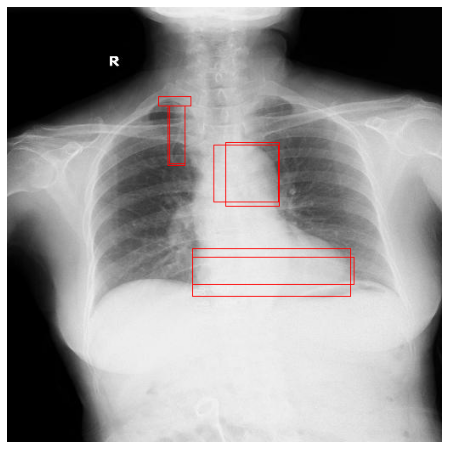

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
def get_dataloaders(df, trn_idx, val_idx):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataset = VBDDataset(train_, train_dir, get_train_transform())
    valid_dataset = VBDDataset(valid_, train_dir, get_valid_transform())


    train_data_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=1,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=1,
        collate_fn=collate_fn
    )
    
    return train_data_loader, valid_data_loader



def train_model(model, dataloader, device, epochs, optimizer, lr_scheduler, fold):
    
    best_loss = 1e10
    loss_hist = Averager()
    itr = 1
    all_losses = []

    for epoch in range(epochs):
        loss_hist.reset() 
    
        for images, targets, image_ids in dataloader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)
            all_losses.append(loss_value)
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1
        
        # saving the model based on training loss for now. - later can be moved to validation
        if loss_hist.value < best_loss:
            best_loss = loss_hist.value
            torch.save(model.state_dict(), f'fasterrcnn_model_{fold}.pt')

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}\n")
        
    return all_losses
        
        
def validate_model(model, dataloader, device):
    print("\n Starting Validation ... ")
    loss_hist = Averager()
    itr = 1

    loss_hist.reset() 

    for images, targets, image_ids in dataloader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    print(f"\nFinal loss: {loss_hist.value}")


   

In [ ]:
def run_fold(fold):
    print(f"Starting fold {fold}")
    start = time.time()
    trn_idx = train_df[train_df['fold'] != fold].index
    val_idx = train_df[train_df['fold'] == fold].index
    
    
    trainloader, valloader = get_dataloaders(train_df, trn_idx, val_idx)
    
    loss_hist = train_model(model, trainloader, device, epochs, optimizer, lr_scheduler, fold)
    
    # plot training loss
    plt.figure(figsize=(8,5))
    plt.plot(loss_hist)
    plt.title("Training Loss Statistic", size=17)
    plt.xlabel("Iteration", size=15)
    plt.ylabel("Loss Value", size=15)
    plt.show()
    
    validate_model(model, valloader, device)
    
    print(f"Completed Fold {fold} in {round(time.time()-start, 2)} seconds")

In [ ]:
model.to(device)

# set params for model
params = [p for p in model.parameters() if p.requires_grad]

# set optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# set lr scheduler
lr_scheduler = None

# set epochs
epochs = 20

# set folds
num_folds = 1

In [ ]:
for fold in range(num_folds):
    run_fold(fold)

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()
clss = targets[1]['labels'].cpu().numpy().astype(np.int32)

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box, clas in zip(boxes, clss):
    cv2.putText(sample, f"{classes[clas]}", (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (255, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)